In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
# Load the dataset
df = pd.read_csv('function_assignment.csv')
df.head()

,function,job_title,jds
0,Sales/ Business Development/ Account Management,Head - Digital Portfolio,NaN
1,IT/ Information Technology,Software Head,10-15 years of experience in a VFX facility Ad...
2,Software Architecting,iPhone Developers,Candidate Should have Strong OO design and pro...
3,Software Architecting,Html/css Developer Job,Job Description Must have at -least . Years ex...
4,Software Architecting,Asp.net Developer Job,Develop ASP.netweb applicationsPerform unit te...


In [10]:

print('Shape:', df.shape)
print('Columns:', df.columns.tolist())


print(df.info())
print(df.describe())


print(df.isnull().sum())


Shape: (10145, 3)
Columns: ['function', 'job_title', 'jds']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10145 entries, 0 to 10144
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   function   10145 non-null  object
 1   job_title  10145 non-null  object
 2   jds        8349 non-null   object
dtypes: object(3)
memory usage: 237.9+ KB
None
                                               function  \
count                                             10145   
unique                                              351   
top     Sales/ Business Development/ Account Management   
freq                                               1245   

                           job_title  \
count                          10145   
unique                          7236   
top     Business Development Manager   
freq                              41   

                                                      jds  
count                            

In [11]:
print(df['job_title'].value_counts().describe())
print(df['job_title'].value_counts().head(10))

count    7236.000000
mean        1.402018
std         1.377754
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        41.000000
Name: count, dtype: float64
job_title
Business Development Manager          41
Project Manager                       34
Marketing Manager                     29
Sales/Business Development Manager    22
HR Manager                            22
Regional Sales Manager                22
Sales Manager                         22
Operations Manager                    20
Area Sales Manager                    19
Business Analyst                      18
Name: count, dtype: int64


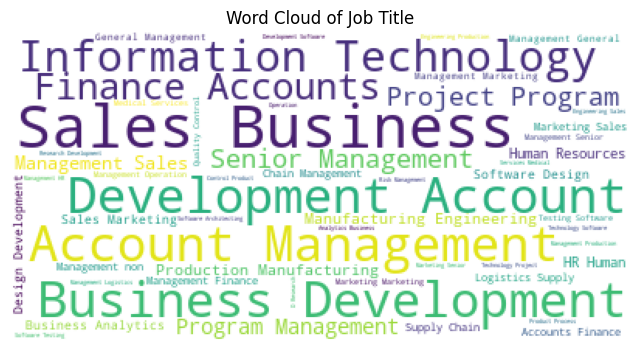

In [13]:
# Import the WordCloud class
import wordcloud
from wordcloud import WordCloud


df['job_title'] = df['job_title'].apply(lambda x: str(x) if isinstance(x, float) else x)

# Textual Data Exploration (Optional, if keeping 'jds')
if 'jds' in df.columns:
    
    wordcloud = WordCloud(background_color='white').generate(' '.join(df['function']))
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Word Cloud of Job Title')
    plt.show()


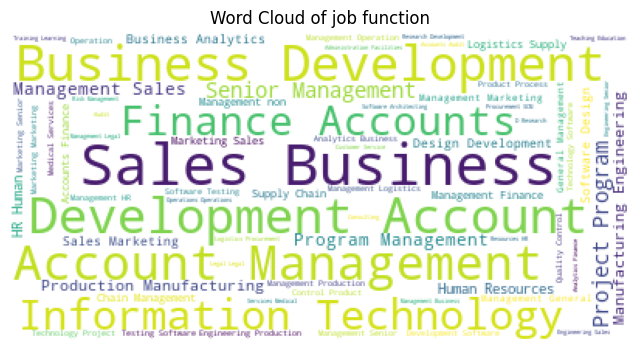

In [14]:


df['function'] = df['function'].apply(lambda x: str(x) if isinstance(x, float) else x)

# Textual Data Exploration (Optional, if keeping 'jds')
if 'jds' in df.columns:
    # Word Cloud (Optional)
    wordcloud = WordCloud(background_color='white').generate(' '.join(df['function']))
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Word Cloud of job function')
    plt.show()


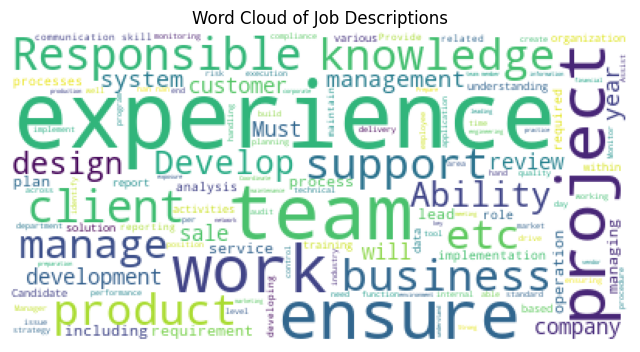

In [15]:


df['jds'] = df['jds'].apply(lambda x: str(x) if isinstance(x, float) else x)

# Textual Data Exploration (Optional, if keeping 'jds')
if 'jds' in df.columns:
    # Word Cloud (Optional)
    wordcloud = WordCloud(background_color='white').generate(' '.join(df['jds']))
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Word Cloud of Job Descriptions')
    plt.show()


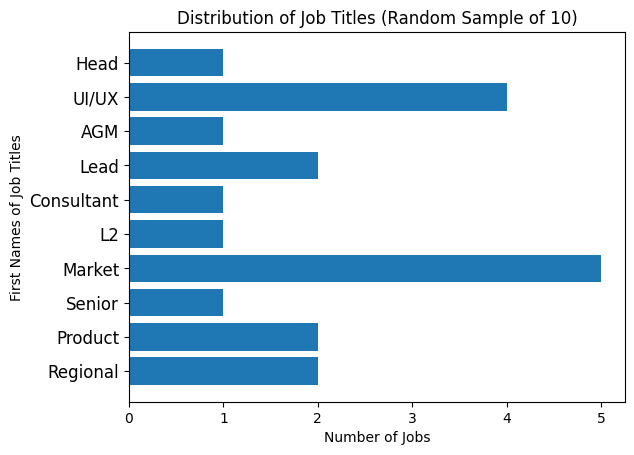

In [16]:
# Randomly sample 10 job titles
sampled_job_titles = df['job_title'].sample(n=10, random_state=42)

# Extract first names of sampled job titles
first_names = [title.split()[0] for title in sampled_job_titles]

# Plot Job Title Distribution with proper space between first names
plt.barh(first_names, job_title_counts[sampled_job_titles].values) 
plt.xlabel('Number of Jobs')  
plt.ylabel('First Names of Job Titles') 
plt.title('Distribution of Job Titles (Random Sample of 10)')  # Update title to reflect the random sample
plt.gca().invert_yaxis()  

# Customize y-axis ticks and labels with larger font size
plt.yticks(range(len(first_names)), first_names, fontsize=12)  # Adjust fontsize as needed

plt.show()

## Data cleaning and preprocessing

In [17]:
from sklearn.impute import SimpleImputer


imputer = SimpleImputer(strategy='most_frequent')
df['jds_cleaned'] = imputer.fit_transform(df[['jds']])[:, 0]  
# Verify the result
print(df['jds_cleaned'].head())

0                                                  nan
1    10-15 years of experience in a VFX facility Ad...
2    Candidate Should have Strong OO design and pro...
3    Job Description Must have at -least . Years ex...
4    Develop ASP.netweb applicationsPerform unit te...
Name: jds_cleaned, dtype: object


In [19]:

## preprocessing

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer

# # Data Cleaning using Stopwords Removal
# stop_words = set(stopwords.words('english'))

# def remove_stopwords(text):
#     if pd.isnull(text):  # Check for missing values
#         return ''
#     word_tokens = word_tokenize(text)
#     filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
#     return ' '.join(filtered_text)



# text
def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)

    # Lowercase, remove punctuation, tokenize
    text = text.lower().replace(r"[^a-zA-Z0-9\s]", "")
    tokens = text.split()

    # Stopword removal and stemming/lemmatization (choose one)
    # Stopword removal with stemming
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    filtered_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

    # Stopword removal with lemmatization (recommended)
    from nltk.stem import WordNetLemmatizer
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return " ".join(filtered_tokens)

df['jds_clean'] = df['jds'].apply(preprocess_text)



In [20]:
# Check for duplicates in specific columns
duplicates_in_columns = df.duplicated(subset=['function', 'job_title', 'jds']).sum()
print("Number of duplicates in specified columns:", duplicates_in_columns)


Number of duplicates in specified columns: 1505


In [21]:

df_cleaned = df.drop_duplicates()
print("Shape after removing duplicates:", df_cleaned.shape)



Shape after removing duplicates: (8640, 5)


In [22]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
tfidf_features = tfidf.fit_transform(df['jds_cleaned'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, df['job_title'], test_size=0.2, random_state=42)



In [23]:
# CNN Pipeline

def create_cnn_pipeline(df_cleaned):

    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(df_cleaned['jds_cleaned'])
    return tokenizer

tokenizer = create_cnn_pipeline(df_cleaned)

X_train_sequences = tokenizer.texts_to_sequences(df_cleaned['jds_cleaned'])  
X_train_padded = pad_sequences(X_train_sequences, maxlen=200)

X_test_sequences = tokenizer.texts_to_sequences(df_cleaned['jds_cleaned'])  #
X_test_padded = pad_sequences(X_test_sequences, maxlen=200)
